In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os, signal
import cv2
import seaborn as sns
import pickle
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import models,Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
DATA_DIR='C:\g_images\downloads\originals'
CLASSES = ['cats','dogs','panda','bikes','horse']

In [4]:
training_data=[] #list
training_label=[]
training_data_raw=[] #list
training_label_raw=[]

img_resize = 250

def self_generated_train_data():
    for c in CLASSES:
        path = os.path.join(DATA_DIR,c)
        class_no = CLASSES.index(c)
        for img in os.listdir(path):
            #print(os.path.join(path,img))
            img_array_bgr = cv2.imread(os.path.join(path,img))
            rgb_img = cv2.cvtColor(img_array_bgr, cv2.COLOR_BGR2RGB)
            rgb_image_resized = cv2.resize(rgb_img,(img_resize,img_resize)) #cv2.resize() follows (width,height) unlike as expected (height, width)
            training_data.append(rgb_image_resized) #append array to a list
            training_label.append(class_no)
            training_data_raw.append(rgb_img) #append array to a list
            training_label_raw.append(class_no)
            
        print("Class %d loaded: %s "%(class_no,c))

In [5]:
self_generated_train_data()

Class 0 loaded: cats 
Class 1 loaded: dogs 
Class 2 loaded: panda 
Class 3 loaded: bikes 
Class 4 loaded: horse 


In [6]:
pickle_out=open("training_data_250px.pickle",'wb')
pickle.dump(training_data,pickle_out)
pickle_out.close()

pickle_out=open("training_label_250px.pickle",'wb')
pickle.dump(training_label,pickle_out)
pickle_out.close()

pickle_out=open("training_data_250px_raw.pickle",'wb')
pickle.dump(training_data_raw,pickle_out)
pickle_out.close()

In [ ]:
# to load the resized data
pickle_in = open("training_data_250px.pickle",'rb')
training_data = pickle.load(pickle_in)

pickle_in = open("training_data_250px.pickle",'rb')
training_label = pickle.load(pickle_in)

pickle_in = open("training_data_250px.pickle",'rb')
training_data_raw = pickle.load(pickle_in)

In [7]:
# Convert into an array for model input
training_data = np.array(training_data)
training_label = np.array(training_label)

In [8]:
print("Training data shape:",training_data.shape)
print("Training label shape:",training_label.shape)

Training data shape: (2750, 250, 250, 3)
Training label shape: (2750,)


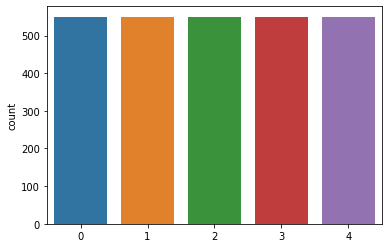

In [9]:
sns.countplot(training_label)

In [10]:
Class_label_counters = {label:list(training_label).count(label) for label in list(training_label)}
print('Class counts:',Class_label_counters)

Class counts: {0: 550, 1: 550, 2: 550, 3: 550, 4: 550}


In [11]:
total_classes = len(np.unique(training_label))
print('Total Number of classes:',total_classes)

Total Number of classes: 5


In [12]:
y_categorical = to_categorical(training_label,total_classes)

In [13]:
# Normalize the data 
training_data = training_data.astype('float32') / 255.

In [14]:
#shuffle the dataset
x_shuffle,y_shuffle = shuffle(training_data,y_categorical,random_state=14)
x_shuffle_raw,_ = shuffle(training_data_raw,y_categorical,random_state=14)

In [15]:
# test data split
X, X_test, Y, Y_test = train_test_split(x_shuffle,y_shuffle,test_size = 0.10,random_state=15)
_, X_test_raw, _, _ = train_test_split(x_shuffle_raw,y_shuffle,test_size = 0.10,random_state=15)

In [16]:
# train and valid data split
X_train,X_valid,Y_train,Y_valid = train_test_split(X,Y,test_size = 0.20)

In [17]:
print("Test data shape after split:",X_test.shape)

Test data shape after split: (275, 250, 250, 3)


In [18]:
print("Training data shape after split:",X_train.shape)
print("Validation data shape after split:",X_valid.shape)

Training data shape after split: (1980, 250, 250, 3)
Validation data shape after split: (495, 250, 250, 3)


In [19]:
print("Training label shape after split:",Y_train.shape)
print("Validation label shape after split:",Y_valid.shape)

Training label shape after split: (1980, 5)
Validation label shape after split: (495, 5)


In [20]:
# Hyper-parameters settings
image_size = X_train.shape[1]
input_shape = (image_size, image_size, 3)
batch_size = 40
kernel_size = 3
pool_size = 2
dropout = 0.5

In [21]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu',input_shape=input_shape,))
model.add(MaxPooling2D(pool_size))

model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))

model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))
#model.add(Dropout(dropout))

model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))
#model.add(Dropout(dropout))

model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))


model.add(GlobalAveragePooling2D())

model.add(Dense(total_classes, activation='softmax')) # output layer is 5-dim one-hot vector


W0908 20:52:08.825170  4168 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 16)      2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 118, 118, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 116, 116, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 32)        0

In [23]:
# loss function for one-hot vector encoding is categorical_crossentropy
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
model.layers[-2].output_shape #GAP layer

(None, 128)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0.001,
                                       patience=10,
                                       verbose=1, 
                                       mode='min',
                                       restore_best_weights=True)

In [26]:
model_checkpoint = ModelCheckpoint('best_model_CAM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
reduce_LR_OnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=5)

In [28]:
# Training the convnet using data-augmentation generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [29]:
training_batch_size = 64
train_generator = train_datagen.flow(X_train, y = Y_train,batch_size = training_batch_size)
print("Number of Batches",len(train_generator))

Number of Batches 31


In [30]:
# OR validation dataset can also be augmented only if validation consists of normal data that doesn't matches with training data
validation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [31]:
validation_batch_size = 32
validation_generator = validation_datagen.flow(X_valid,y= Y_valid,batch_size=validation_batch_size)
print("Number of Batches",len(validation_generator))

Number of Batches 16


In [32]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = X_train.shape[0]//training_batch_size,
    epochs = 200,
    validation_data = validation_generator,
    validation_steps = X_valid.shape[0]//validation_batch_size,
    callbacks=[early_stopping,model_checkpoint,reduce_LR_OnPlateau])

Epoch 1/200
29/30 [============================>.] - ETA: 2s - loss: 1.6096 - acc: 0.2052
Epoch 00001: val_acc improved from -inf to 0.37917, saving model to best_model_CAM.h5
30/30 [==============================] - 108s 4s/step - loss: 1.6080 - acc: 0.2062 - val_loss: 1.5623 - val_acc: 0.3792
Epoch 2/200
29/30 [============================>.] - ETA: 2s - loss: 1.5124 - acc: 0.3207
Epoch 00002: val_acc did not improve from 0.37917
30/30 [==============================] - 106s 4s/step - loss: 1.5084 - acc: 0.3231 - val_loss: 1.5519 - val_acc: 0.3604
Epoch 3/200
29/30 [============================>.] - ETA: 2s - loss: 1.4240 - acc: 0.3596
Epoch 00003: val_acc did not improve from 0.37917
30/30 [==============================] - 110s 4s/step - loss: 1.4228 - acc: 0.3586 - val_loss: 1.3827 - val_acc: 0.3604
Epoch 4/200
29/30 [============================>.] - ETA: 2s - loss: 1.3823 - acc: 0.4133
Epoch 00004: val_acc improved from 0.37917 to 0.41042, saving model to best_model_CAM.h5
30/30

Epoch 61/200
29/30 [============================>.] - ETA: 2s - loss: 0.4351 - acc: 0.8159
Epoch 00061: val_acc did not improve from 0.80000
30/30 [==============================] - 91s 3s/step - loss: 0.4340 - acc: 0.8152 - val_loss: 0.5163 - val_acc: 0.7875
Epoch 62/200
29/30 [============================>.] - ETA: 2s - loss: 0.4319 - acc: 0.8224
Epoch 00062: val_acc did not improve from 0.80000
30/30 [==============================] - 87s 3s/step - loss: 0.4320 - acc: 0.8231 - val_loss: 0.5166 - val_acc: 0.7833
Epoch 63/200
29/30 [============================>.] - ETA: 2s - loss: 0.4426 - acc: 0.8213Restoring model weights from the end of the best epoch.

Epoch 00063: val_acc did not improve from 0.80000
30/30 [==============================] - 83s 3s/step - loss: 0.4407 - acc: 0.8215 - val_loss: 0.4834 - val_acc: 0.7833
Epoch 00063: early stopping


In [ ]:
# # train the network
# history = model.fit(X_train, Y_train, 
#                     epochs=60, 
#                     batch_size=batch_size,
#                     validation_data = (X_valid,Y_valid),
#                     callbacks=[early_stopping,model_checkpoint,reduce_LR_OnPlateau])

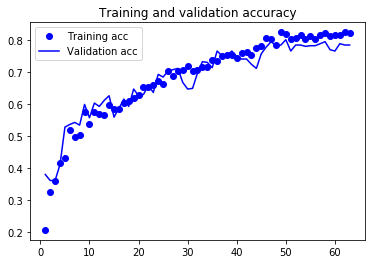

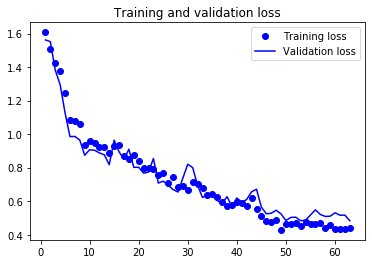

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [34]:
model.save('cam_model.h5')

In [55]:
model.evaluate(X_test,Y_test)

495/495 [==============================] - 5s 11ms/sample - loss: 0.4939 - acc: 0.8000


[0.4939290141818499, 0.8]

In [36]:
model.layers[-1].name #last layer name

'dense'

In [37]:
classifier_weights = model.layers[-1].get_weights()[0] #last layer weights

In [38]:
print('Shape of Weight: ',classifier_weights.shape)

Shape of Weight:  (128, 5)


In [39]:
# create new model that will return two output
cam_model = Model(inputs=model.input,
                  outputs=(model.layers[-3].output, model.layers[-1].output)) 

In [40]:
Activation_maps, Predict_prob = cam_model.predict(X_test)

In [41]:
print('Total Activation maps:',len(Activation_maps))
print('Activation shape:',Activation_maps.shape)

Total Activation maps: 275
Activation shape: (275, 20, 20, 128)


In [51]:
def cam_plot(datasetSize = X_test,dataset_2 = X_test_raw, plotting = True):
    
    num_images = 10

    random_test_image_ind = np.random.randint(datasetSize.shape[0], size=num_images)

    if plotting:
        plt.figure(figsize=(20, 6))

    for i,image_index in enumerate(random_test_image_ind):

        Activation_map_for_one_img = Activation_maps[image_index, :, :, :]

        pred_id = np.argmax(Predict_prob[image_index])

        predicted_class_weights = classifier_weights[:,pred_id]

        cam = np.zeros(dtype = np.float32, shape = Activation_map_for_one_img.shape[0:2])

        for j, w in enumerate(predicted_class_weights):

            cam += np.dot(w, Activation_map_for_one_img[:, :, j])

        cam/=np.max(cam)

        cam = cv2.resize(cam, (dataset_2[image_index].shape[1], dataset_2[image_index].shape[0]))

        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

        heatmap = np.maximum(heatmap,0)
        heatmap[np.where(cam<0.15)]=0

        superimposed_img = heatmap*0.4 + (dataset_2[image_index])

        if plotting:
            
            ax = plt.subplot(2, num_images/2, i+1)
            plt.imshow(np.uint8(superimposed_img))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        fn = 'image_'+str(image_index)+'.jpg'
        cv2.imwrite(fn, (superimposed_img))
        

In [52]:
#cam_plot(dataset_2=X_test_raw)

In [53]:
start_time = time.time()
for i in range(50):
    cam_plot(dataset_2=X_test_raw,plotting=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 177.4478783607483 seconds ---
